In [58]:
%matplotlib notebook

In [210]:
import calour as ca
from calour.training import plot_roc
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from sklearn.metrics import roc_curve
from emperor import Emperor, nbinstall


In [385]:
ldlr = ca.read_amplicon('data/microbiome/ldlr-deblur-refererence-hit-2k-wtax.biom', 
                        'data/combined_sample_metadata_HFD.txt', min_reads=100, normalize=100)

2018-08-16 17:08:39 WARNING These have metadata but do not have data - dropped (460): {'11548.A19.101.5', '11548.A20.108.14', '11548.A19.103.6', '11548.A19.101.6', '11548.A18.97.10', '11548.A22.114.4', '11548.A21.110.18', '11548.A20.105.19', '11548.A21.109.11', '11548.A22.116.6', '11548.A23.118.16', '11548.A19.104.5', '11548.A18.99.12', '11548.A18.99.9', '11548.A21.110.20', '11548.A23.119.11', '11548.A19.104.20', '11548.A19.104.18', '11548.A21.111.20', '11548.A20.107.6', '11548.A18.98.8', '11548.A18.100.11', '11548.A23.120.2', '11548.A18.98.20', '11548.A21.110.4', '11548.A20.105.10', '11548.A19.103.2', '11548.A19.102.9', '11548.A19.102.6', '11548.A20.108.5', '11548.A18.97.3', '11548.A23.119.1', '11548.A18.100.20', '11548.A22.116.10', '11548.A23.118.13', '11548.A22.115.12', '11548.A18.100.10', '11548.A21.110.5', '11548.A20.108.2', '11548.A22.116.2', '11548.A23.118.6', '11548.A22.115.15', '11548.A20.106.18', '11548.A19.102.10', '11548.A22.114.17', '11548.A20.107.9', '11548.A23.117.1', '1

In [61]:
apoe = ca.read_amplicon('data/microbiome/apoe-deblur-reference-hit-2k-wtax.biom',
                        'data/combined_sample_metadata_HFD.txt', min_reads=100, normalize=100)
apoe = apoe.filter_samples('body_habitat', 'UBERON:feces').filter_samples('diet', 'HFD')

2018-07-26 20:00:49 WARNING These have metadata but do not have data - dropped: {'10422.20.F.13', '10422.21.F.4', '10422.23.F.9', '10422.28.F.9', '10422.21.F.10', '10422.26.F.3', '10422.22.F.12', '10422.18.F.13', '10422.18.F.10', '10422.24.F.10', '10422.17.F.4', '10422.29.F.4', '10422.32.F.12', '10422.30.F.3', '10422.26.F.4', '10422.19.F.2', '10422.21.F.3', '10422.23.F.8', '10422.17.F.5', '10422.30.F.7', '10422.22.F.1', '10422.19.F.9', '10422.22.F.4', '10422.17.F.9', '10422.24.F.4', '10422.28.F.1', '10422.29.F.1', '10422.31.F.3', '10422.32.F.7', '10422.23.F.12', '10422.24.F.6', '10422.30.F.6', '10422.20.F.4', '10422.18.F.6', '10422.30.F.9', '10422.17.F.6', '10422.23.F.4', '10422.17.F.11', '10422.22.F.9', '10422.21.F.7', '10422.23.F.10', '10422.26.F.7', '10422.28.F.5', '10422.24.F.5', '10422.22.F.3', '10422.20.F.7', '10422.21.F.11', '10422.18.F.9', '10422.27.F.8', '10422.31.F.6', '10422.29.F.10', '10422.17.F.10', '10422.19.F.4', '10422.27.F.7', '10422.17.F.13', '10422.20.F.12', '10422.2

In [62]:
exp = apoe.join_experiments(ldlr)

In [63]:
exp

AmpliconExperiment ("join apoe-deblur-reference-hit-2k-wtax.biom & ldlr-deblur-refererence-hit-2k-wtax.biom") with 642 samples, 8648 features

# PCoA

In [117]:
bc_dm = beta_diversity("braycurtis", exp.data.astype(int))

In [128]:
bc_dm.ids = exp.sample_metadata.index

In [129]:
ordin = pcoa(bc_dm)

/Users/zech/miniconda3/envs/calour/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.6147754177676623 and the largest is 63.1067246026248.
  RuntimeWarning


In [130]:
x = (Emperor(ordin, exp.sample_metadata, remote=True)
     .color_by('genotype', colormap='Dark2'))
x

In [64]:
exp.sample_metadata.genotype.value_counts()

ApoE KO          460
LDLR knockout    182
Name: genotype, dtype: int64

# APOE and LDLR models

In [65]:
#exp2 = exp.filter_prevalence(field='genotype', cutoff=0.000001, fraction=0.01).filter_samples('age', [10, 10.5], negate=True)
exp2 = exp.filter_prevalence(field='genotype', cutoff=0.000001, fraction=0.01).filter_samples('age', [10, 10.5], negate=True)
exp2

2018-07-26 20:00:54 WARNING Do you forget to normalize your data? It is required before running this function


AmpliconExperiment ("join apoe-deblur-reference-hit-2k-wtax.biom & ldlr-deblur-refererence-hit-2k-wtax.biom") with 582 samples, 437 features

In [9]:
exp2_apoe = exp2.filter_samples('genotype', 'ApoE KO')
exp2_apoe

AmpliconExperiment ("join apoe-deblur-reference-hit-2k-wtax.biom & ldlr-deblur-refererence-hit-2k-wtax.biom") with 412 samples, 437 features

In [10]:
exp2_apoe.sample_metadata.exposure_type.value_counts()

Air    211
IHC    201
Name: exposure_type, dtype: int64

In [11]:
exp2_ldlr = exp2.filter_samples('genotype', 'LDLR knockout')
exp2_ldlr.sample_metadata.exposure_type.value_counts()

Air    85
IHC    85
Name: exposure_type, dtype: int64

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score

In [13]:
it_apoe = exp2_apoe.classify('exposure_type',
                             RandomForestClassifier(n_estimators=500),
                             GroupKFold(5).split(
                                 exp2_apoe.data, exp2_apoe.sample_metadata['exposure_type'], exp2_apoe.sample_metadata['mouse_number']))

In [14]:
res_apoe = next(it_apoe)

In [66]:
res_apoe.head()

,Air,IHC,Y_TRUE,SAMPLE,CV
0,0.208,0.792,IHC,11548.A19.104.3,0
1,0.980,0.020,Air,11548.A21.112.11,0
2,0.922,0.078,Air,11548.A21.112.8,0
3,0.958,0.042,Air,11548.A22.113.17,0
4,0.066,0.934,IHC,11548.A20.105.17,0


In [77]:
from calour import training

In [75]:
%load_ext autoreload
%autoreload 2

In [82]:
from importlib import reload

In [105]:
reload(training)

<module 'calour.training' from '/Users/zech/Dropbox/git/calour/calour/training.py'>

In [111]:
        prob = np.arange(0, 1, 0.1)
        result = pd.DataFrame({'pos': 1-prob,
                               'neg': prob,
                               'Y_TRUE': ['pos'] * 9 + ['neg'],
                               'CV': [0, 1] * 5})


<IPython.core.display.Javascript object>


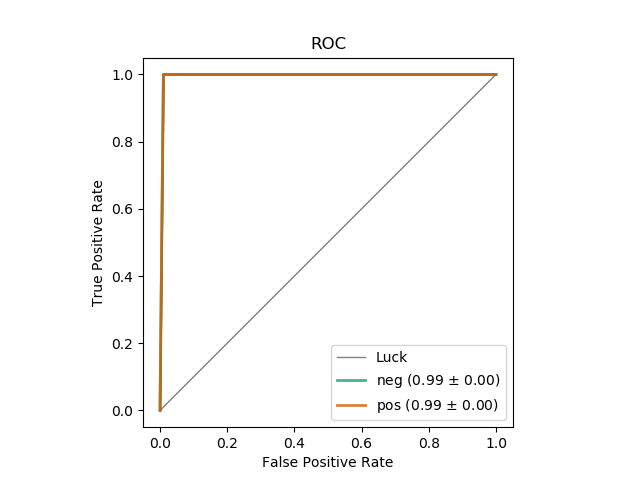

2018-07-27 15:22:46 WARNING The cross validation fold 0 is skipped because the true positive rate or false positive rate computation failed. This is likely because you have either no true positive or no negative samples in this cross validation for the class 'neg'
2018-07-27 15:22:46 WARNING The cross validation fold 0 is skipped because the true positive rate or false positive rate computation failed. This is likely because you have either no true positive or no negative samples in this cross validation for the class 'pos'


/Users/zech/miniconda3/envs/calour/lib/python3.5/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/zech/miniconda3/envs/calour/lib/python3.5/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [112]:
training.plot_roc(result)

<IPython.core.display.Javascript object>


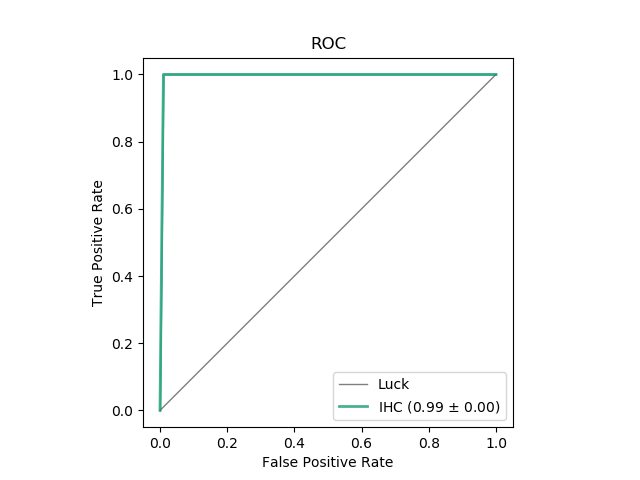

2018-07-27 15:00:43 WARNING The cross validation 'IHC' is skipped because the true positive rate or false positive rate computation failed. This is likely because you have either no true positive or no negative samples in this cross validation for the class 4
[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.6

/Users/zech/miniconda3/envs/calour/lib/python3.5/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [106]:
training.plot_roc(res_apoe, classes=['IHC'], cv=True)

In [26]:
clf_apoe = RandomForestClassifier(500, oob_score=True)
clf_apoe.fit(exp2_apoe.data, exp2_apoe.sample_metadata.exposure_type)
clf_apoe.oob_score_

0.9975728155339806

In [27]:
res_apoe2ldlr = pd.DataFrame(clf_apoe.predict_proba(exp2_ldlr.data))
res_apoe2ldlr.columns = clf_apoe.classes_
res_apoe2ldlr['Y_TRUE'] = exp2_ldlr.sample_metadata['exposure_type'].values
res_apoe2ldlr['CV'] = 0

<IPython.core.display.Javascript object>


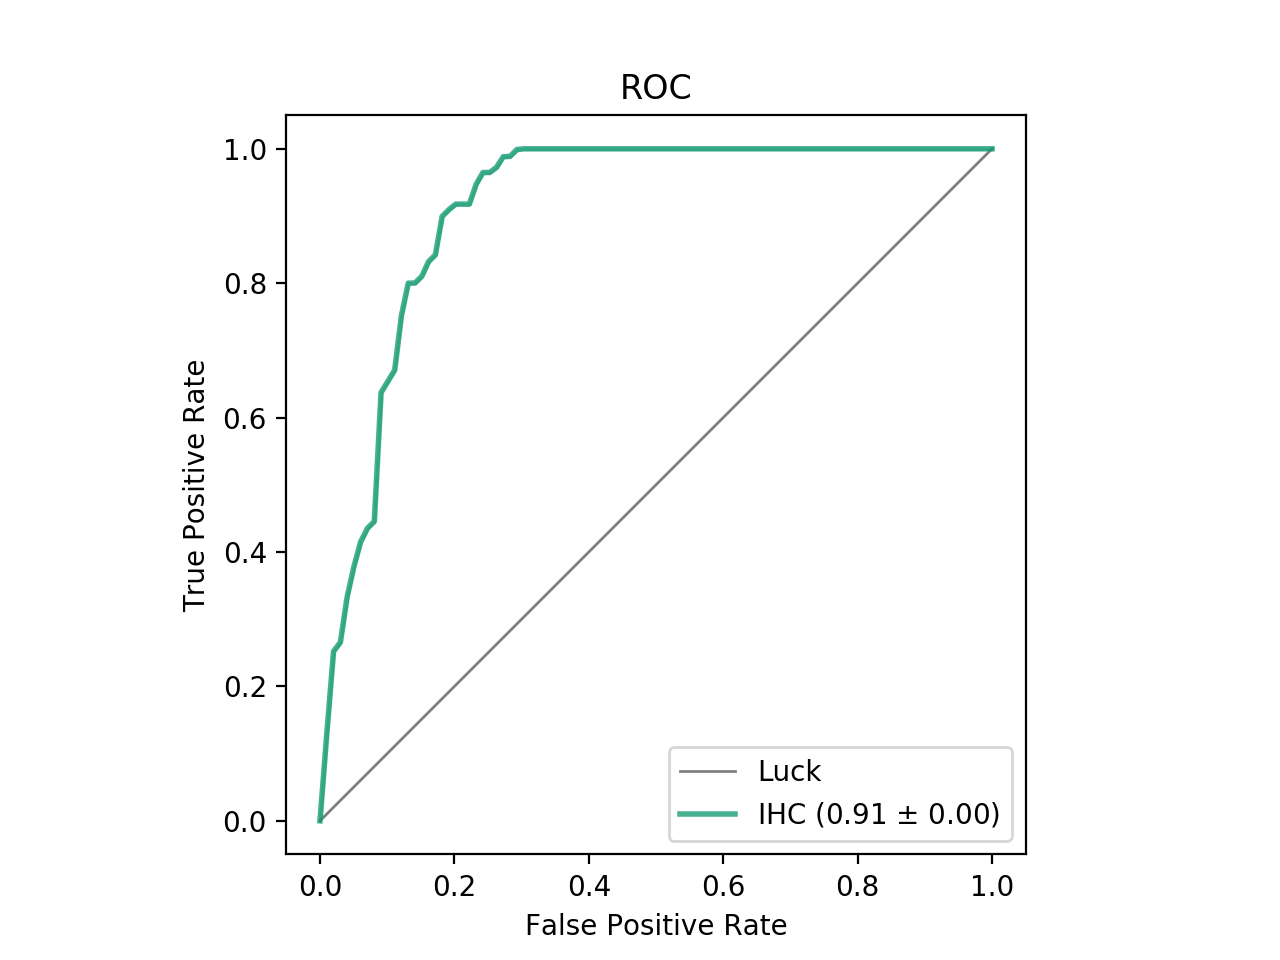

In [28]:
plot_roc(res_apoe2ldlr, classes=['IHC'])

In [32]:
it_ldlr = exp2_ldlr.classify('exposure_type', RandomForestClassifier(n_estimators=500),
                             GroupKFold(5).split(
                                 exp2_ldlr.data, exp2_ldlr.sample_metadata['exposure_type'], exp2_ldlr.sample_metadata['mouse_number']))

In [33]:
res_ldlr = next(it_ldlr)

In [34]:
res_ldlr.head()

,Air,IHC,Y_TRUE,SAMPLE,CV
0,0.140,0.860,IHC,10422.17.F.10,0
1,0.104,0.896,IHC,10422.17.F.11,0
2,0.066,0.934,IHC,10422.17.F.12,0
3,0.092,0.908,IHC,10422.17.F.13,0
4,0.202,0.798,IHC,10422.17.F.3,0


<IPython.core.display.Javascript object>


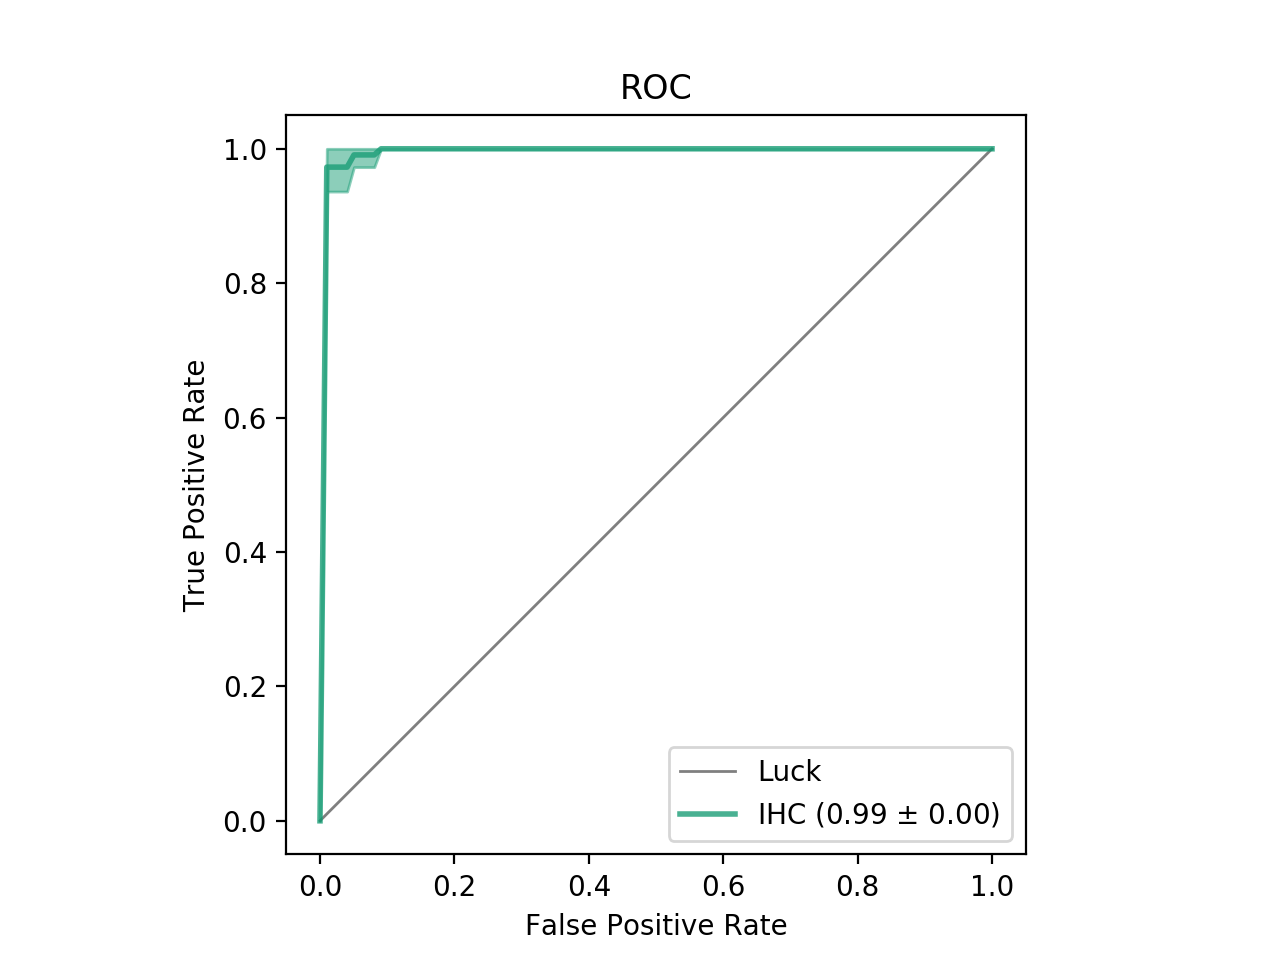

In [35]:
plot_roc(res_ldlr, classes=['IHC'])

In [36]:
clf_ldlr = RandomForestClassifier(500, oob_score=True)
clf_ldlr.fit(exp2_ldlr.data, exp2_ldlr.sample_metadata.exposure_type)
clf_ldlr.oob_score_

0.9588235294117647

In [37]:
res_ldlr2apoe = pd.DataFrame(clf_ldlr.predict_proba(exp2_apoe.data))
res_ldlr2apoe.columns = clf_ldlr.classes_
res_ldlr2apoe['Y_TRUE'] = exp2_apoe.sample_metadata['exposure_type'].values
res_ldlr2apoe['CV'] = 0

<IPython.core.display.Javascript object>


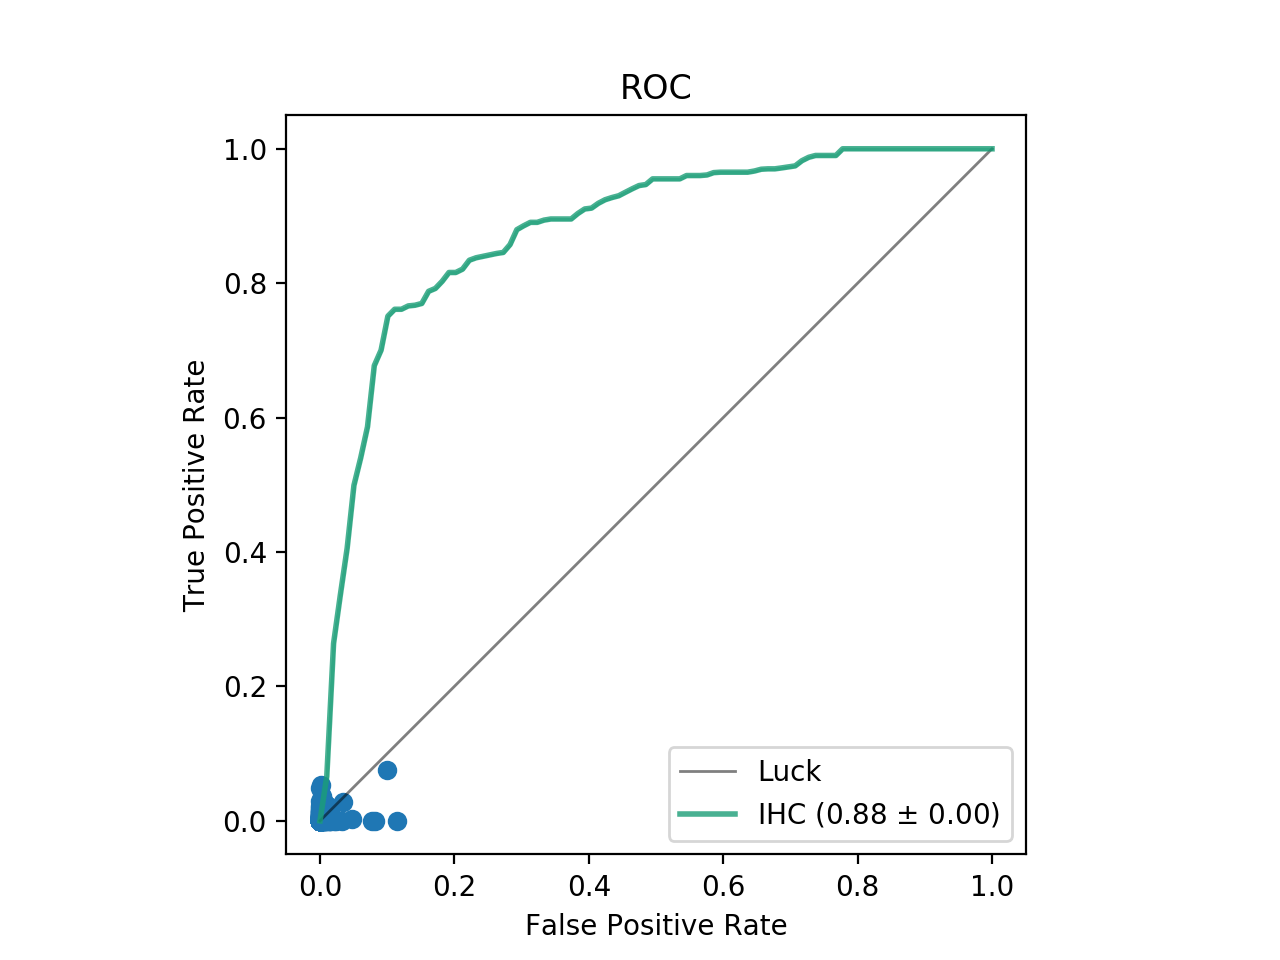

In [38]:
plot_roc(res_ldlr2apoe, classes=['IHC'])

# feature imp

In [39]:
imp = pd.DataFrame({'apoe': clf_apoe.feature_importances_,
                    'ldlr': clf_ldlr.feature_importances_})

In [40]:
imp_rank = imp.rank(ascending=False)

In [41]:
imp.head()

,apoe,ldlr
0,0.003339,0.001406
1,0.000239,0.000000
2,0.000029,0.000000
3,0.000123,0.000000
4,0.000000,0.000000


In [42]:
imp_rank.head()

,apoe,ldlr
0,49.0,115.0
1,199.0,340.5
2,317.0,340.5
3,241.0,340.5
4,384.5,340.5


In [43]:
plt.scatter(imp.apoe, imp.ldlr)

In [44]:
plt.scatter(imp_rank.apoe, imp_rank.ldlr)

In [45]:
exp2.feature_metadata['apoe_imp'] = imp.apoe.values
exp2.feature_metadata['ldlr_imp'] = imp.ldlr.values
exp2.feature_metadata['apoe_imp_rank'] = imp_rank.apoe.values
exp2.feature_metadata['ldlr_imp_rank'] = imp_rank.ldlr.values

2018-07-26 18:50:08 WARNING Do you forget to normalize your data? It is required before running this function


<IPython.core.display.Javascript object>


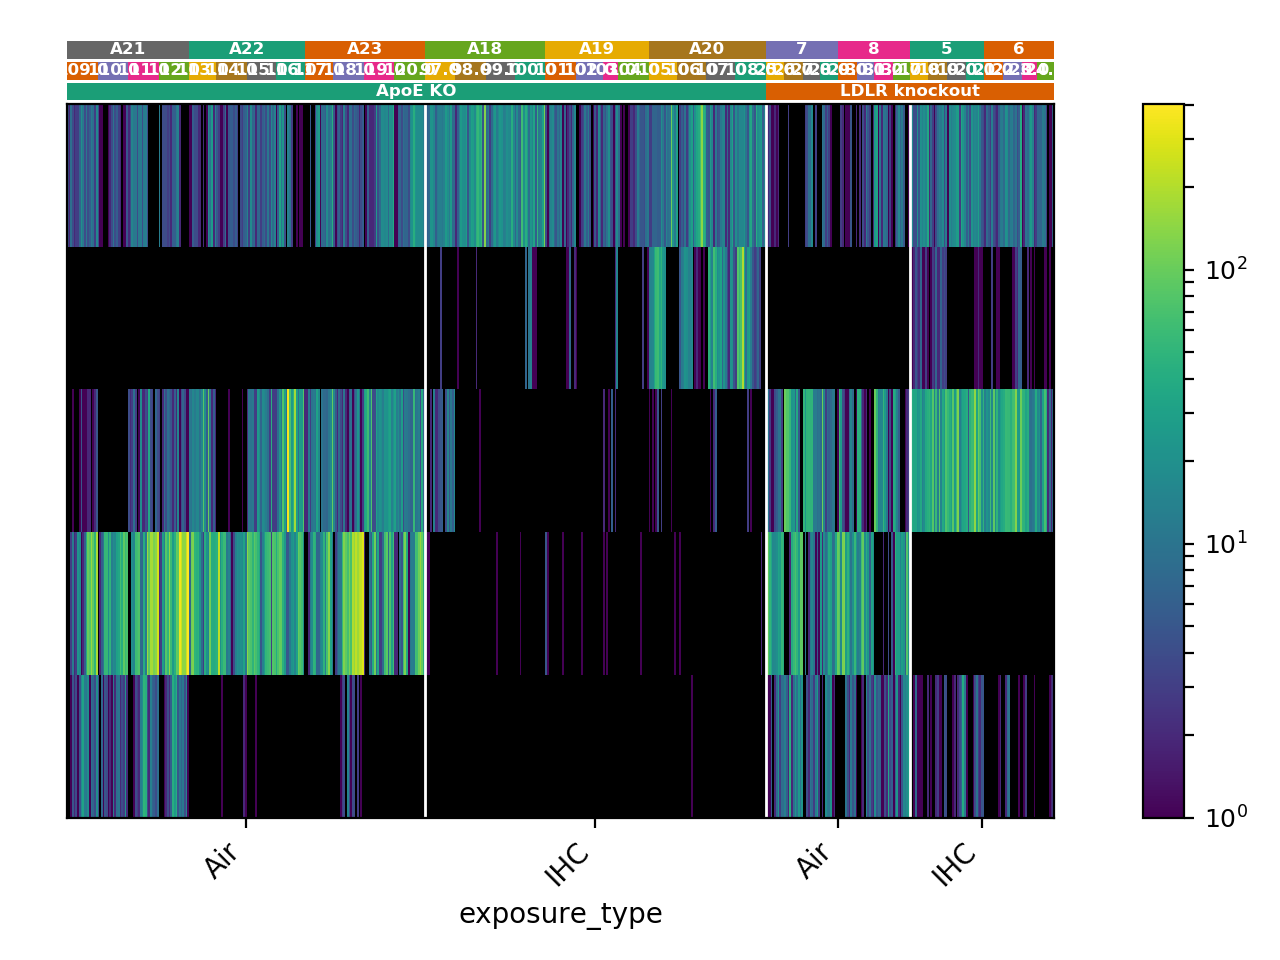

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [50]:
n = 30
exp3 = (exp2.filter_by_metadata('ldlr_imp_rank', lambda x: [i < n for i in x], axis=1)
         .filter_by_metadata('apoe_imp_rank', lambda x: [i < n for i in x], axis=1))
(exp3
     .sort_samples('age')
     .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype')
     .cluster_features()
     .plot(sample_field='exposure_type', barx_fields=['genotype', 'mouse_number', 'cage_number'], gui='jupyter'))

In [52]:
import pickle
with open('common-imp-microbes.pkl', 'wb') as f:
    pickle.dump(exp3, f)

In [281]:
features = []
for i in exp3.feature_metadata.index:
    df = pd.DataFrame({'abundance': exp3[:, i],
                       'taxonomy': exp3.feature_metadata.loc[i, 'taxonomy'],
                       'genotype': exp3.sample_metadata['genotype'],
                       'age': exp3.sample_metadata['age'],
                       'exposure_type': exp3.sample_metadata['exposure_type']})
    features.append(df)

features = pd.concat(features, axis=0)

features.to_csv('common-imp-microbes.tsv', sep='\t')

2018-07-26 18:19:19 WARNING Do you forget to normalize your data? It is required before running this function


<IPython.core.display.Javascript object>


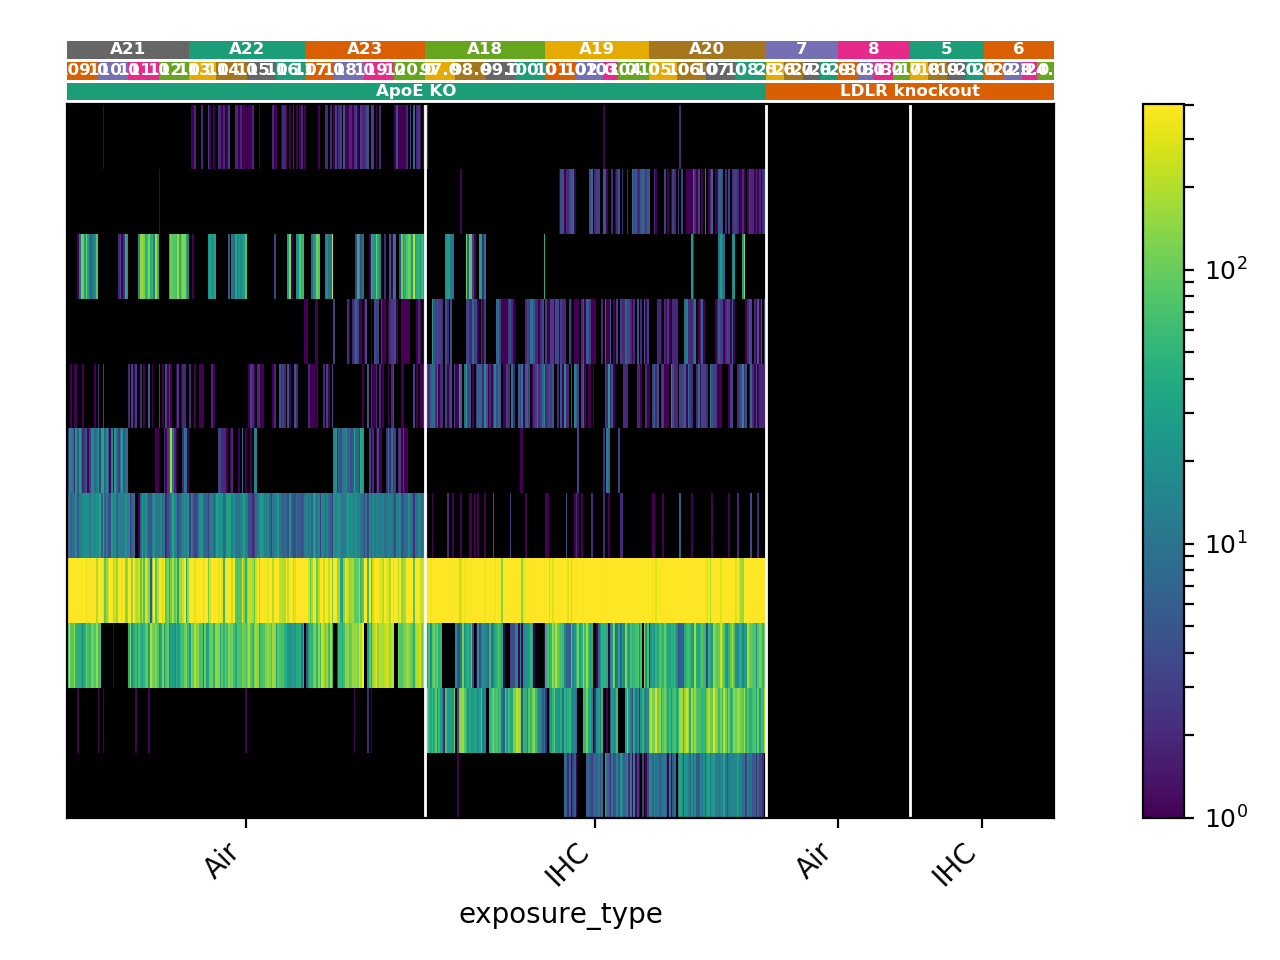

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [47]:
(exp2.filter_by_metadata('ldlr_imp', lambda x: [i==0 for i in x], axis=1)
     .filter_by_metadata('apoe_imp_rank', lambda x: [i < 30 for i in x], axis=1)
     .sort_samples('age')
     .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype')
     .cluster_features()
     .plot(sample_field='exposure_type', barx_fields=['genotype', 'mouse_number', 'cage_number'], gui='jupyter'))

2018-07-26 18:19:24 WARNING Do you forget to normalize your data? It is required before running this function


<IPython.core.display.Javascript object>


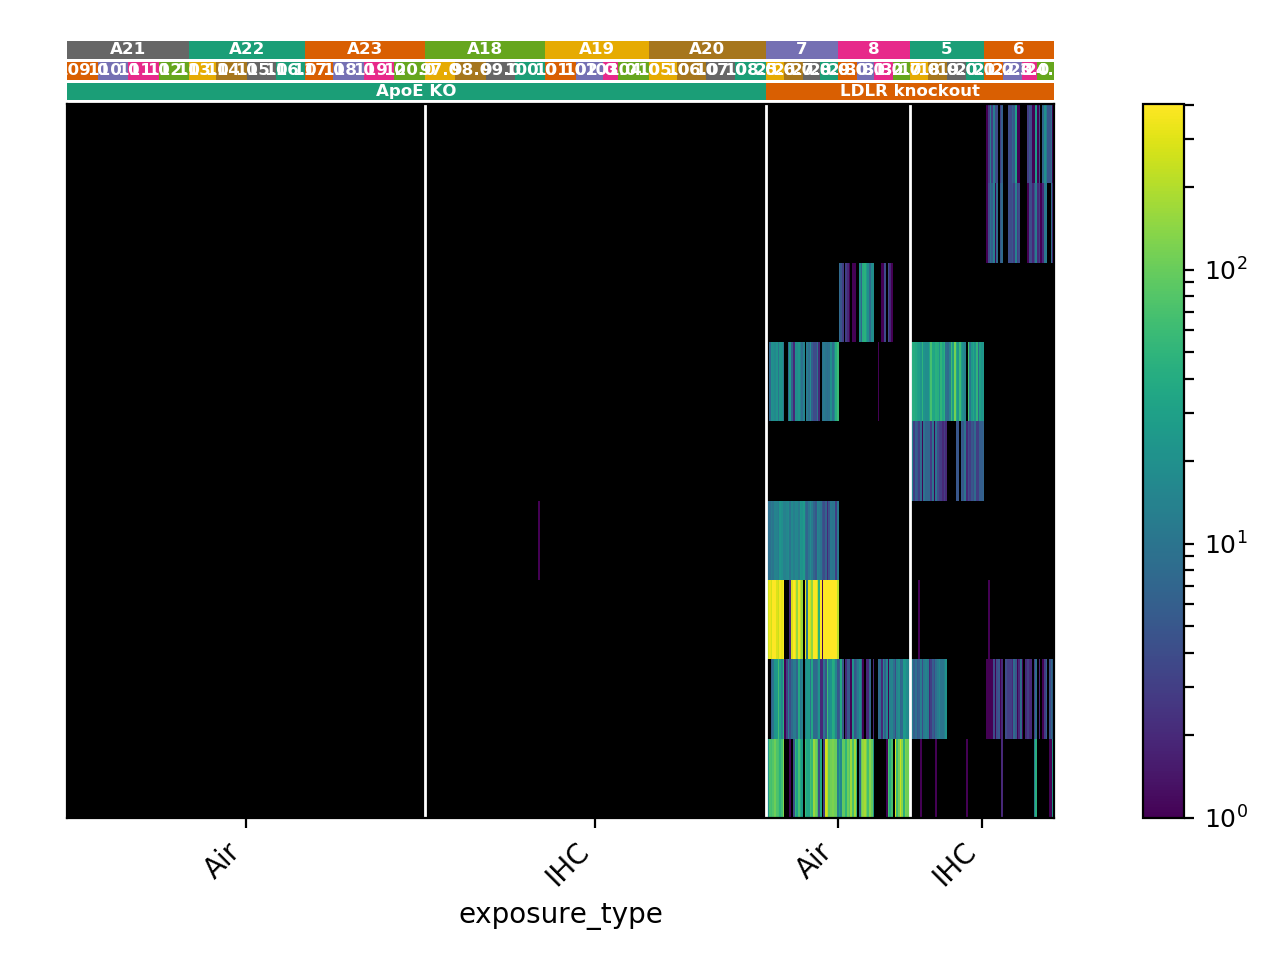

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [48]:
(exp2.filter_by_metadata('apoe_imp', lambda x: [i==0 for i in x], axis=1)
     .filter_by_metadata('ldlr_imp_rank', lambda x: [i < 30 for i in x], axis=1)
     .sort_samples('age')
     .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype')
     .cluster_features()
     .plot(sample_field='exposure_type', 
           barx_fields=['genotype', 'mouse_number', 'cage_number'], gui='jupyter'))

# diff abundance

In [165]:
exp2_apoe_diff = exp2_apoe.diff_abundance('exposure_type', val1='Air', val2='IHC', alpha=0.01, p)

2018-07-30 15:41:32 WARNING Do you forget to normalize your data? It is required before running this function


In [166]:
exp2_ldlr_diff = exp2_ldlr.diff_abundance('exposure_type', val1='Air', val2='IHC', alpha=0.01)

2018-07-30 15:41:37 WARNING Do you forget to normalize your data? It is required before running this function


In [167]:
fids = set(exp2_apoe_diff.feature_metadata.index) & set(exp2_ldlr_diff.feature_metadata.index)

In [168]:
len(fids)

42

In [178]:
from sklearn.metrics import roc_auc_score

In [195]:
for i in fids:
    taxon = exp2_apoe.feature_metadata.loc[i, 'taxonomy']
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHC'
    a = roc_auc_score(apoe_true, apoe_score)
    if a < 0.5:
        a = 1 - a
    print('-------')
    print(taxon)
    print(i)
    print('APOE: {:.3f}'.format(a))
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHC'
    a = roc_auc_score(ldlr_true, ldlr_score)
    if a < 0.5:
        a = 1 - a
    print('LDLR: {:.3f}'.format(a))

-------
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__SMB53;s__
TACGTAGGGGGCTAGCGTTATCCGGAATTACTGGGCGTAAAGGGTGCGTAGGTGGTTTCTTAAGTCAGAGGTGAAAGGCTACGGCTCAACCGTAGTAAGCCTTTGAAACTGGGAAACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGT
APOE: 0.718
LDLR: 0.571
-------
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__;s__
TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGACTTTTAAGTGAGATGTGAAATACTCGGGCTCAACTTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAATGGAATTCTTAG
APOE: 0.543
LDLR: 0.882
-------
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;g__;s__
TACGTAGGGGGCTAGCGTTATCCGGAATTACTGGGCGTAAAGGGTGCGTAGGTGGTTTCTTAAGTCAGAGGTGAAAGGCTACGGCTCAACCGTAGTAAGCCTTTGAAACTGGGGAACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGT
APOE: 0.677
LDLR: 0.629
-------
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__
TACGTAGGGGGCGAGCGTTATCCGGATTCACTGGGTGTAAAGGGAGCGTAGACGGCCATGCAAGCCAGGGGTGAAAGCCCGGGGCCCAACCCCGGGACTGCCCTTGGAACTGC

In [205]:
exp2_com = exp2.filter_ids(['TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGACTTTTAAGTGAGATGTGAAATACTCGGGCTCAACTTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAATGGAATTCCTAG',
                            'TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAGCGCAAGTCTGGAGTGAAATGCCGGGGCCCAACCCCGGAACTGCTTTGGAAACTGTGCAGCTCGAGTGCAGGAGAGGTAAGCGGAATTCCTAG',
                            'TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGGGCGCAGACGGCGATGCAAGCCAGGAGTGAAAGCCCGGGGCCCAACCCCGGGACTGCTCTTGGAACTGCGTGGCTGGAGTGCAGGAGGGGCAGGCGGAATTCCTGG',
                            'TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGCCTGCCAAGTCTGATGTGAAATACCGGGGCTCAACCCCGGGGCTGCATTGGAAACTGGCAGGCTGGAGTGCCGGAGAGGCAGGCGGAATTCCTAG'],
                           axis=1)

<IPython.core.display.Javascript object>


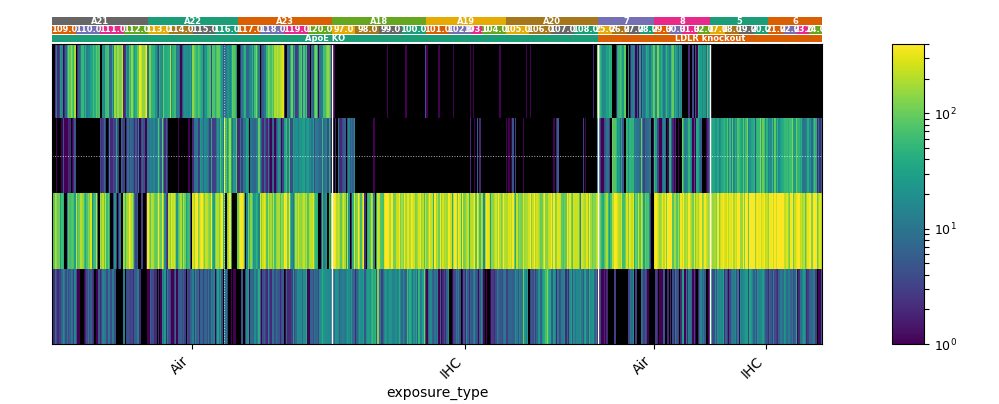

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [206]:
(exp2_com
     .sort_samples('age')
     .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype')
     #.cluster_features()
     .plot(sample_field='exposure_type', barx_fields=['genotype', 'mouse_number', 'cage_number'], gui='jupyter'))

In [208]:
exp2_apoe

AmpliconExperiment ("join apoe-deblur-reference-hit-2k-wtax.biom & ldlr-deblur-refererence-hit-2k-wtax.biom") with 412 samples, 437 features

<IPython.core.display.Javascript object>


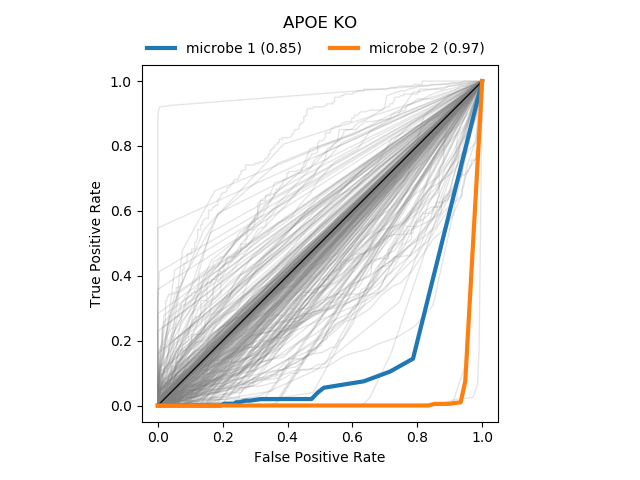

Text(0.5,1.08,'APOE KO')

In [369]:
from matplotlib import pyplot as plt
fig_apoe, ax_apoe = plt.subplots()
ax_apoe.set_aspect('equal')

fids_apoe = []
for i in exp2_apoe.feature_metadata.index:
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHC'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if a > 0.75:
        fids_apoe.append(i)
    ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=1, color='gray', alpha=0.2)

ax_apoe.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_apoe.set_xlim(-0.05, 1.05)
ax_apoe.set_ylim(-0.05, 1.05)
ax_apoe.set_xlabel('False Positive Rate')
ax_apoe.set_ylabel('True Positive Rate')
ax_apoe.set_title('APOE KO',  y=1.08)

<IPython.core.display.Javascript object>


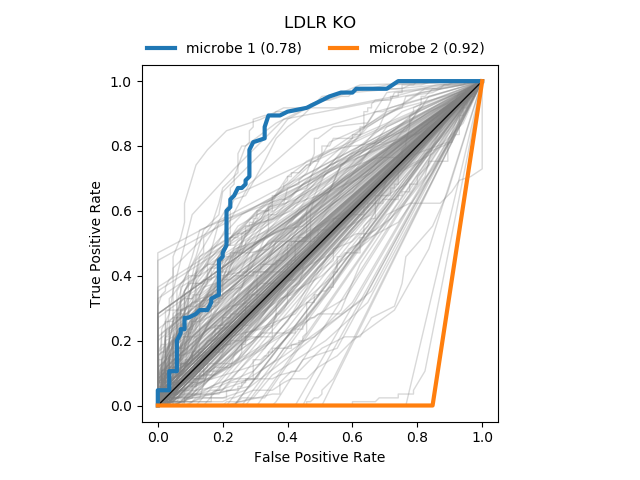

Text(0.5,1.08,'LDLR KO')

In [370]:
from matplotlib import pyplot as plt
fig_ldlr, ax_ldlr = plt.subplots()
ax_ldlr.set_aspect('equal')
fids_ldlr = []

for i in exp2_ldlr.feature_metadata.index:
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHC'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if a > 0.75:
        fids_ldlr.append(i)
    ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=1, color='gray', alpha=0.3)

ax_ldlr.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_ldlr.set_xlim(-0.05, 1.05)
ax_ldlr.set_ylim(-0.05, 1.05)
ax_ldlr.set_xlabel('False Positive Rate')
ax_ldlr.set_ylabel('True Positive Rate')
ax_ldlr.set_title('LDLR KO',  y=1.08)

In [371]:
fids = list(set(fids_apoe) & set(fids_ldlr))

In [372]:
fids.sort()

In [373]:
print(fids)

['TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAGCGCAAGTCTGGAGTGAAATGCCGGGGCCCAACCCCGGAACTGCTTTGGAAACTGTGCAGCTCGAGTGCAGGAGAGGTAAGCGGAATTCCTAG', 'TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGACTTTTAAGTGAGATGTGAAATACTCGGGCTCAACTTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAATGGAATTCCTAG']


In [374]:
features = []
for n, i in enumerate(fids, 1):
    df = pd.DataFrame({'abundance': exp2[:, i],
                       'taxonomy': 'microbe %d:' % n + exp2.feature_metadata.loc[i, 'taxonomy'],
                       'feature': i,
                       'genotype': exp2.sample_metadata['genotype'],
                       'age': exp2.sample_metadata['age'],
                       'exposure_type': exp2.sample_metadata['exposure_type']})
    #df['taxonomy'] = 
    features.append(df)

features = pd.concat(features, axis=0)

features.to_csv('common-imp-microbes.tsv', sep='\t')

In [375]:
for n, (i, c) in enumerate(zip(fids, plt.cm.tab10.colors), 1):
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHC'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=c, label='microbe %d (%.2f)' % (n, a))
ax_apoe.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False, loc="lower left")
fig_apoe.tight_layout()

In [376]:
for n, (i, c) in enumerate(zip(fids, plt.cm.tab10.colors), 1):
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHC'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=c, label='microbe %d (%.2f)' % (n, a))
ax_ldlr.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False,  loc="lower left")
fig_ldlr.tight_layout()

In [366]:
from matplotlib.backends.backend_pdf import PdfPages

In [377]:
with PdfPages('roc-microbes.pdf') as pdf:
    pdf.savefig(fig_apoe)
    pdf.savefig(fig_ldlr)

In [378]:
!open roc-microbes.pdf

## r plot


In [380]:
!open trend-microbes.pdf